# Installing, Cloning & Importing

In [ ]:
!pip install tensorflow==2.1

     |████████████████████████████████| 421.8MB 39kB/s 
     |████████████████████████████████| 3.9MB 55.9MB/s 
     |████████████████████████████████| 450kB 61.6MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=86aaa8198496ab306b8d7aafc78e22df81a0fcf5ec1d7002f3ff37783ee42090
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installatio

In [ ]:
 !pip install keras-tuner

     |████████████████████████████████| 61kB 1.9MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=aea4228112463717e6610f43488cfcbc4e3d7e926524ebb6677f1c985732bd06
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=c8ea2eae55c9d8791ed393e31bf3395fd5455e8c328ffa1009f64f14c478eb51
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
# Update dataset: !git pull
!git clone https://github.com/casperbh96/COVID-19-Detection.git dataset

Cloning into 'dataset'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 9745 (delta 4), reused 0 (delta 0), pack-reused 9736
Receiving objects: 100% (9745/9745), 151.88 MiB | 12.39 MiB/s, done.
Resolving deltas: 100% (74/74), done.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2, time
import tensorflow as tf


tf.__version__

'2.1.0'

In [ ]:
import kerastuner

kerastuner.__version__

'1.0.1'

# Loading The Datasets

In [ ]:
covid_path = 'dataset/covid_dataset.csv'
covid_image_path = 'dataset/covid_adjusted/'

normal_path = 'dataset/normal_xray_dataset.csv'
normal_image_path = 'dataset/normal_dataset/'

covid_df = pd.read_csv(covid_path, usecols=['filename', 'finding'])
normal_df = pd.read_csv(normal_path, usecols=['filename', 'finding'])

normal_df = normal_df.head(99)

covid_df.head()

,filename,finding
0,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,COVID-19
1,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,COVID-19
2,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,COVID-19
3,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,COVID-19
4,nejmc2001573_f1a.jpeg.jpg,COVID-19


In [ ]:
covid_images = []
covid_labels = []

for index, row in covid_df.iterrows():
    filename = row['filename']
    label = row['finding']
    path = covid_image_path + filename

    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    covid_images.append(image)
    covid_labels.append(label)

normal_images = []
normal_labels = []

for index, row in normal_df.iterrows():
    filename = row['filename']
    label = row['finding']
    path = normal_image_path + filename

    # temporary fix while we preprocess ALL the images
    if filename == '4c268764-b5e5-4417-85a3-da52916984d8.jpg':
        break

    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    normal_images.append(image)
    normal_labels.append(label)

# normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255

# normalize to interval of [0,1]
normal_images = np.array(normal_images) / 255

# Splitting Datasets Into Training and Testing

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping

# split into training(0.7) and testing(0.15) and validation(0.15)
covid_x_train, covid_x_val, covid_y_train, covid_y_val= train_test_split(
    covid_images, covid_labels, test_size=0.3)
covid_x_test, covid_x_val, covid_y_test, covid_y_val= train_test_split(
    covid_x_val, covid_y_val, test_size=0.5)

normal_x_train, normal_x_val, normal_y_train, normal_y_val = train_test_split(
    normal_images, normal_labels, test_size=0.3)
normal_x_test, normal_x_val, normal_y_test, normal_y_val = train_test_split(
    normal_x_val, normal_y_val, test_size=0.5)



X_train = np.concatenate((normal_x_train, covid_x_train), axis=0)
X_val = np.concatenate((normal_x_val, covid_x_val), axis=0)
X_test = np.concatenate((normal_x_test, covid_x_test), axis=0)
y_train = np.concatenate((normal_y_train, covid_y_train), axis=0)
y_val = np.concatenate((normal_y_val, covid_y_val), axis=0)
y_test = np.concatenate((normal_y_test, covid_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_val = LabelBinarizer().fit_transform(y_val)
y_val = to_categorical(y_val)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)# split into training(0.7) and testing(0.15) and validation(0.15)
covid_x_train, covid_x_val, covid_y_train, covid_y_val= train_test_split(
    covid_images, covid_labels, test_size=0.3)
covid_x_test, covid_x_val, covid_y_test, covid_y_val= train_test_split(
    covid_x_val, covid_y_val, test_size=0.5)

normal_x_train, normal_x_val, normal_y_train, normal_y_val = train_test_split(
    normal_images, normal_labels, test_size=0.3)
normal_x_test, normal_x_val, normal_y_test, normal_y_val = train_test_split(
    normal_x_val, normal_y_val, test_size=0.5)



X_train = np.concatenate((normal_x_train, covid_x_train), axis=0)
X_val = np.concatenate((normal_x_val, covid_x_val), axis=0)
X_test = np.concatenate((normal_x_test, covid_x_test), axis=0)
y_train = np.concatenate((normal_y_train, covid_y_train), axis=0)
y_val = np.concatenate((normal_y_val, covid_y_val), axis=0)
y_test = np.concatenate((normal_y_test, covid_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_val = LabelBinarizer().fit_transform(y_val)
y_val = to_categorical(y_val)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

Using TensorFlow backend.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)


# Modeling With Keras

In [ ]:
from tensorflow import keras
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Activation
from tensorflow.keras.layers import BatchNormalization,Dropout
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

In [ ]:
def build_model(hp):  # random search passes this hyperparameter() object 
    vggModel = VGG19(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))
    outputs = vggModel.output

    outputs = Conv2D(512,(1, 1), strides = (1, 1), name = 'conv0')(outputs)
    outputs = BatchNormalization(axis = 3, name = 'bn0')(outputs)
    outputs = Activation('relu')(outputs) # shape=(?, 238, 238, 32)
    outputs = MaxPooling2D((2, 2), name='max_pool0')(outputs) # shape=(?, 59, 59, 32

    outputs = Conv2D(512,(1, 1), strides = (1, 1), name = 'conv1')(outputs)
    outputs = BatchNormalization(axis = 3, name = 'bn1')(outputs)
    outputs = Activation('relu')(outputs) # shape=(?, 238, 238, 32)

    outputs = Dropout(0.5)(outputs)

    outputs = Conv2D(512,(1, 1), strides = (1, 1), name = 'conv2')(outputs)
    outputs = BatchNormalization(axis = 3, name = 'bn2')(outputs)
    outputs = Activation('relu')(outputs) # shape=(?, 238, 238, 32)
    outputs = MaxPooling2D((2, 2), name='max_pool1')(outputs)

    outputs = Flatten(name="flatten")(outputs)
    outputs = Dropout(0.5)(outputs)
    outputs = Dense(2, activation="softmax")(outputs)

    model = Model(inputs=vggModel.input, outputs=outputs)

    for layer in vggModel.layers:
        layer.trainable = False

    model.compile(
       optimizer=keras.optimizers.Adam(
                hp.Float(
                    'learning_rate',
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling='LOG',
                    default=1e-3
                )
            ),
        loss='categorical_crossentropy', 
        
        metrics=['accuracy']  )

    return model


In [ ]:
import time
LOG_DIR = f"{int(time.time())}"

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=1,  # how many model variations to test?
    executions_per_trial=1,  # how many trials per variation? (same model could perform differently)
    directory=LOG_DIR)
# earlystop = EarlyStopping(monitor = 'loss',patience = 5, baseline = None)
tuner.search(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val),
                    validation_steps=len(X_val) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=320)

80142336/80134624 [==============================] - 6s 0us/step
  ...
    to  
  ['...']
Train for 4.15625 steps, validate on 29 samples
Epoch 1/320
5/4 [====================================] - 9s 2s/step - loss: 21.4535 - accuracy: 0.5338 - val_loss: 105.0669 - val_accuracy: 0.5172
Epoch 2/320
5/4 [====================================] - 1s 281ms/step - loss: 31.3266 - accuracy: 0.5564 - val_loss: 93.5712 - val_accuracy: 0.5172
Epoch 3/320
5/4 [====================================] - 1s 275ms/step - loss: 11.7493 - accuracy: 0.6015 - val_loss: 305.4667 - val_accuracy: 0.5172
Epoch 4/320
5/4 [====================================] - 1s 275ms/step - loss: 8.0946 - accuracy: 0.6241 - val_loss: 55.4226 - val_accuracy: 0.5172
Epoch 5/320
5/4 [====================================] - 2s 303ms/step - loss: 7.4308 - accuracy: 0.5489 - val_loss: 57.1693 - val_accuracy: 0.5517
Epoch 6/320
5/4 [====================================] - 1s 275ms/step - loss: 5.3699 - accuracy: 0.6767 - val_loss: 81.

INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.get_best_hyperparameters()[0].values

{'learning_rate': 0.009964547779368166}

In [ ]:
tuner.get_best_models()[0].summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
modelBest = tuner.get_best_models()[0]

In [ ]:

history = modelBest.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val),
                    validation_steps=len(X_val) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=200)



  ...
    to  
  ['...']
Train for 4.15625 steps, validate on 29 samples
Epoch 1/200
5/4 [====================================] - 2s 437ms/step - loss: 0.1253 - accuracy: 0.9474 - val_loss: 1.3824 - val_accuracy: 0.7931
Epoch 2/200
5/4 [====================================] - 1s 295ms/step - loss: 0.0684 - accuracy: 0.9624 - val_loss: 1.2376 - val_accuracy: 0.7931
Epoch 3/200
5/4 [====================================] - 1s 279ms/step - loss: 0.0710 - accuracy: 0.9774 - val_loss: 1.0033 - val_accuracy: 0.8276
Epoch 4/200
5/4 [====================================] - 1s 282ms/step - loss: 0.1963 - accuracy: 0.9699 - val_loss: 1.2031 - val_accuracy: 0.8276
Epoch 5/200
5/4 [====================================] - 1s 279ms/step - loss: 0.0826 - accuracy: 0.9774 - val_loss: 1.7949 - val_accuracy: 0.7586
Epoch 6/200
5/4 [====================================] - 1s 277ms/step - loss: 0.0614 - accuracy: 0.9774 - val_loss: 2.0869 - val_accuracy: 0.7931
Epoch 7/200
5/4 [============================

In [ ]:
acc_scores = list()
acc = modelBest.evaluate(X_test, y_test, verbose=0)
acc_scores.append(acc[1])
print('Accuracy scores: ', acc_scores)

Accuracy scores:  [0.8965517]


In [ ]:
y_pred = modelBest.predict(X_test, batch_size=32)
y_pred_covid = modelBest.predict(covid_x_test, batch_size=32)

In [ ]:
y_test_covid = LabelBinarizer().fit_transform(covid_y_test)
y_test_covid = to_categorical(y_test_covid)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89        14
           1       0.88      0.93      0.90        15

    accuracy                           0.90        29
   macro avg       0.90      0.90      0.90        29
weighted avg       0.90      0.90      0.90        29



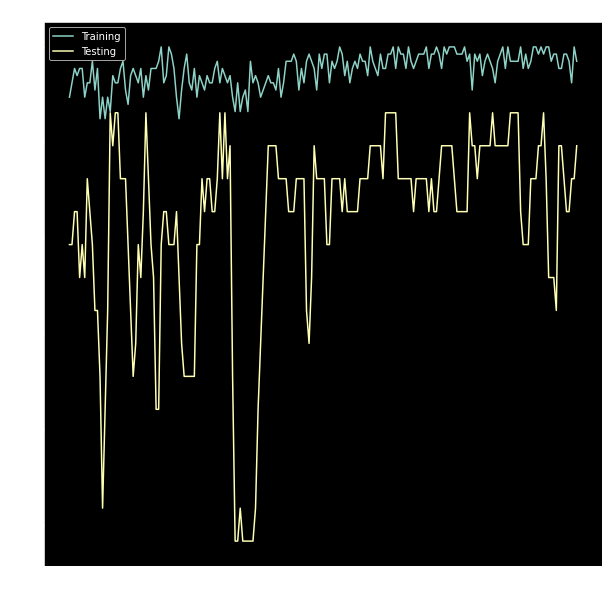

In [ ]:
plt.figure(figsize=(10,10))
plt.style.use('dark_background')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Validation'])

plt.show()

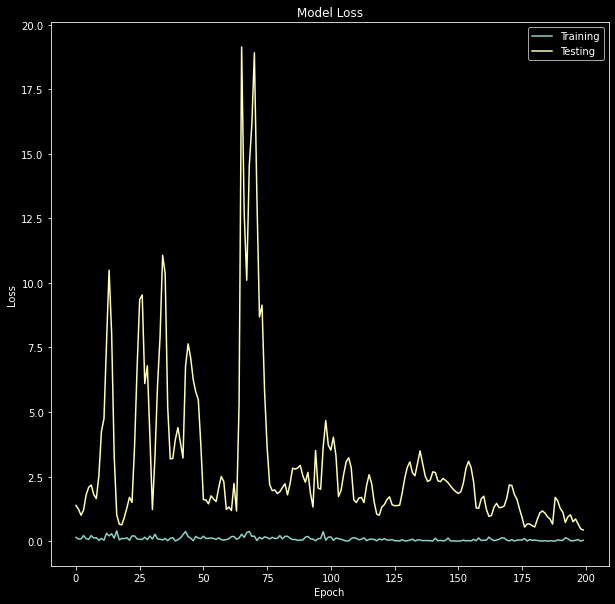

In [ ]:
plt.figure(figsize=(10,10))
plt.style.use('dark_background')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])

plt.show()

In [ ]:
from keras.preprocessing import image

test_image = image.load_img('dataset/normal_dataset/0b421aea-6e0f-4faf-a4bf-4a82445d0e35.jpg', target_size = (224,224))
#test_image = image.load_img('dataset/covid_adjusted/covid-19-pneumonia-rapidly-progressive-12-hours.jpg.jpg', target_size = (224,224))


test_image = image.img_to_array(test_image)
test_image = test_image *1./255

test_image = np.expand_dims(test_image, axis = 0)
test_image = np.vstack([test_image ])
result = modelBest.predict(test_image,batch_size=32)
print(result)

[[9.9917209e-01 8.2792644e-04]]


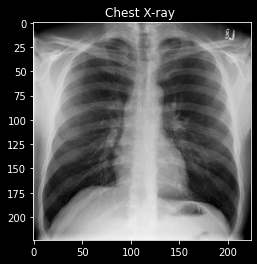

In [ ]:
import matplotlib.image as mpimg

img=mpimg.imread('dataset/normal_dataset/0b421aea-6e0f-4faf-a4bf-4a82445d0e35.jpg')
#img=mpimg.imread('dataset/covid_adjusted/covid-19-pneumonia-rapidly-progressive-12-hours.jpg.jpg')
imgplot = plt.imshow(img)
plt=plt.title('Chest X-ray ')

In [ ]:
if result[0][0]<result[0][1]:

    prediction = 'normal'
else:
    prediction = 'covid'
    
print("AI's prediction is: "+ prediction)

AI's prediction is: covid
